In [1]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from scipy import sparse

the idea is to rank samples by means of <li> pair wise comparison <li> use EM algorithm to transfere pairwise comparisons to absolute value rank. Bradley-Terry model

Pair samples could be samples in <b>dense</b> manner (number of samples equal to number of combinations) or <b>sparse</b> (stochastically sample indexes considere it's prob weights)

### Sampling type study

#### Dense

9 comparisons were done
Each object encountering [4. 4. 4. 4. 4.]


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


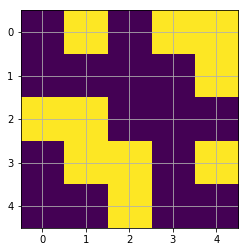

In [19]:
comparisons = np.zeros((5, 5))
for num, (i, j) in enumerate(combinations(range(len(comparisons)), 2)):
    v = np.random.randint(0, 2)
    if v:
        comparisons[i, j] = 1
    else:
        comparisons[j, i] = 1
print('{} comparisons were done'.format(num))
freq = comparisons.sum(0) + comparisons.sum(1)
print('Each object encountering', freq)
plt.imshow(comparisons)
plt.grid('on')

#### Sparse

In [21]:
def sample_pair(comparisons):
    '''
    stochastic solution of sample task
    heuristic is that number of samples should be larger then object numbers by 1 or more  
    '''
    elem_freq = np.abs(np.sum(np.abs(comparisons), 1) - np.sum(np.abs(comparisons), 0)) + 1
    weights = 1/elem_freq
    weights = weights/np.sum(weights)
    indx1, indx2 = np.random.choice(list(range(len(comparisons))), size=2, replace=False, p=weights)
    return indx1, indx2

Each object encountering [1. 3. 4. 1. 3.]


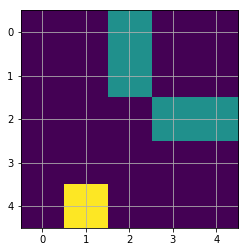

In [22]:
comparisons = np.zeros((5, 5))
for _ in range(6): # 6 euristicaly obtained value
    i, j = sample_pair(comparisons)
    v = np.random.randint(0, 2)
    if v:
        comparisons[i, j] += 1
    else:
        comparisons[j, i] += 1
freq = comparisons.sum(0) + comparisons.sum(1)
print('Each object encountering', freq)
plt.imshow(comparisons)
plt.grid('on')

#### chech objects connectivity

In [148]:
def check_connectivity(comparisons):
    '''
    check whether objects connected in comperison chain. Aka graph is connected
    '''
    num_objects = len(comparisons)
    gr1 = {}; gr2 = {}; #direct and reverse graphs
    def Add_edge(u, v) :
        if u not in gr1 : 
            gr1[u] = []; 
        if v not in gr2 : 
            gr2[v] = [];       
        gr1[u].append(v); 
        gr2[v].append(u); 
    vis1 = [False]*num_objects #visited edges
    vis2 = [False]*num_objects
    def dfs1(x): #depth first search direct
        vis1[x] = True  
        if x not in gr1: 
            gr1[x] = {} 
        for i in gr1[x]:  
            if (not vis1[i]): 
                dfs1(i)  
    def dfs2(x): #depth first search reverse
        vis2[x] = True  
        if x not in gr2: 
            gr2[x] = {} 
        for i in gr2[x]:  
            if (not vis2[i]): 
                dfs2(i)
    # create graph
    edges = list(zip(*sparse.find(comparisons)[:-1]))
    for edge in edges:
        Add_edge(*edge) #add nodes and edges to gr1 (direct) and gr2 (reversed) 
    dfs1(0); # search in direct way
    dfs2(0); # search in reverse way
#     import ipdb; ipdb.set_trace()
    for i in range(num_objects) : 
        # If any vertex it not visited in any direction 
        # Then graph is not connected 
        if (not vis1[i] and not vis2[i]) : 
            return False; 
    # If graph is connected 
    return True; 
    
    

#### find best additive (study euristic)

In [139]:
dim_comperison_range = (5, 20) # range of number of objects 
additive_range = (1,10) # how much above number of object should we compare
num_exp = 20
point = []

for i_ in range(*dim_comperison_range):
    for j_ in range(*additive_range):
        dim_comperison = i_
        additive = j_
        frac_connected = []
        for _ in range(num_exp):
            comparisons = np.zeros((dim_comperison, dim_comperison))
            for _ in range(dim_comperison+additive): # 6 euristicaly obtained value. 
                i, j = sample_pair(comparisons)
                v = np.random.randint(0, 2) # this is not valid actually, because decision is random
                if v:
                    comparisons[i, j] += 1
                else:
                    comparisons[j, i] += 1
            is_connected = check_connectivity(comparisons)
            frac_connected.append(is_connected)
        frac_connected = sum(frac_connected)/num_exp
        point.append((dim_comperison, additive, frac_connected))

In [140]:
point = np.reshape([v for i, j, v in point], 
                   (dim_comperison_range[1]-dim_comperison_range[0], additive_range[1] - additive_range[0]))

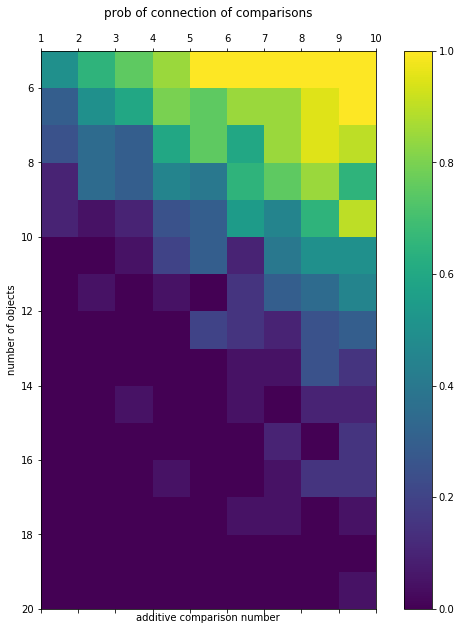

In [141]:
_ = plt.figure(figsize=(10,10))
plt.matshow(point, extent=[additive_range[0],additive_range[1],dim_comperison_range[1],dim_comperison_range[0]], fignum=1)
plt.xlabel('additive comparison number')
plt.ylabel('number of objects')
plt.title('prob of connection of comparisons')
plt.xticks()
plt.colorbar()

Could be seen that a number of additive comparisons should be quite large. But the reason may be is random nature of comparison decision making

#### find best additive (study euristic)

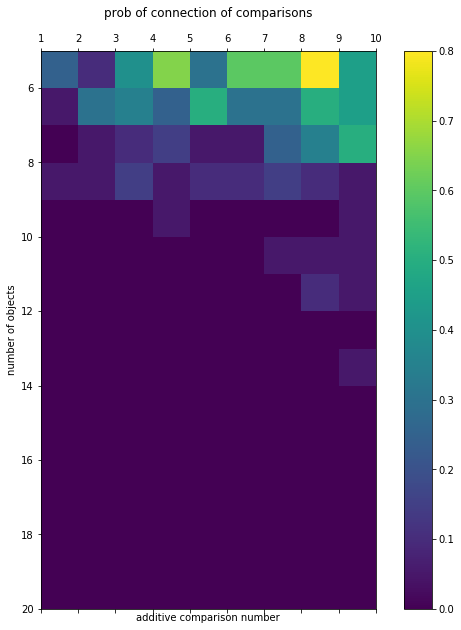

In [149]:
dim_comperison_range = (5, 20) # range of number of objects 
additive_range = (1,10) # how much above number of object should we compare
num_exp = 20
point = []

for i_ in range(*dim_comperison_range):
    for j_ in range(*additive_range):
        dim_comperison = i_
        additive = j_
        frac_connected = []
        for _ in range(num_exp):
            comparisons = np.zeros((dim_comperison, dim_comperison))
            for _ in range(dim_comperison+additive): # 6 euristicaly obtained value. 
                i, j = sample_pair(comparisons)
                if i>=j:
                    comparisons[i, j] += 1
                else:
                    comparisons[j, i] += 1
            is_connected = check_connectivity(comparisons)
            frac_connected.append(is_connected)
        frac_connected = sum(frac_connected)/num_exp
        point.append((dim_comperison, additive, frac_connected))

point = np.reshape([v for i, j, v in point], 
                   (dim_comperison_range[1]-dim_comperison_range[0], additive_range[1] - additive_range[0]))

_ = plt.figure(figsize=(10,10))
plt.matshow(point, extent=[additive_range[0],additive_range[1],dim_comperison_range[1],dim_comperison_range[0]], fignum=1)
plt.xlabel('additive comparison number')
plt.ylabel('number of objects')
plt.title('prob of connection of comparisons')
plt.xticks()
plt.colorbar()

version did not find success

## Class definition

In [2]:
from pairwise import Pair_comp

### Experiment

##### test on digits

as input object ones selected simple intagers - 0, 1, 2 

In [3]:
a = Pair_comp(np.arange(0, 3)[..., np.newaxis])
a.compare_samples()

left object: [0]; right object: [1]
Compare objects (-1: left object win; 0: draw; 1: right object win)
fdsfds


ValueError: invalid literal for int() with base 10: 'fdsfds'

decisions were random

let's check objects

In [4]:
a.show_objects()

Object 0: [0] 
 Score 1.0000
Object 1: [1] 
 Score 1.0000
Object 2: [2] 
 Score 1.0000


fit model

In [5]:
a.fit_bt()

what scires we got

In [6]:
a.show_objects()

Object 0: [0] 
 Score 0.0000
Object 1: [1] 
 Score 0.0001
Object 2: [2] 
 Score 0.9999


add new object

In [7]:
a.add_object(np.array([3]))

object 1: [3]; object 2: [2]
Compare objects (-1: object 1 win; 0: draw; 1: object 2 win)0


fit model with new object

In [8]:
a.fit_bt()

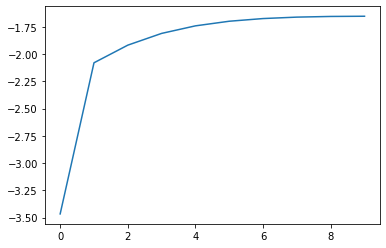

In [9]:
plt.plot(a.ll_log)

how comparison matrix now looks

In [10]:
a.comp_matrix

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 0., 1.],
       [0., 0., 1., 0.]])

And finally how scores looks now

In [11]:
a.show_objects()

Object 0: [0] 
 Score 0.0000
Object 1: [1] 
 Score 0.0127
Object 2: [2] 
 Score 0.2736
Object 3: [3] 
 Score 0.7137


##### test on images

In [4]:
images = np.zeros((6,64,64))
num = 0
for i in range(2):
    for j in range(3):
        images[num, 8*i:8*(i+1), 8*j:8*(j+1)] = 1
        num += 1

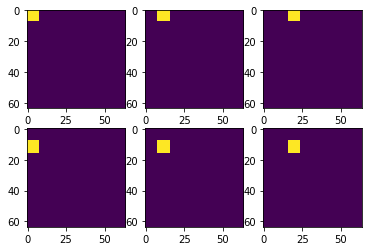

In [5]:
_, ax = plt.subplots(2,3)
ax = ax.flatten()
for i in range(6):
    ax[i].imshow(images[i])
plt.show()

In [6]:
from pairwise import Pair_comp

In [7]:
a = Pair_comp(images[:-1])

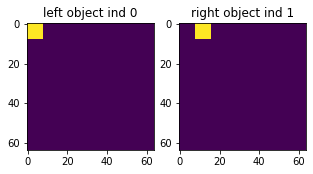

Compare objects (-1: left object win; 0: draw; 1: right object win)
1


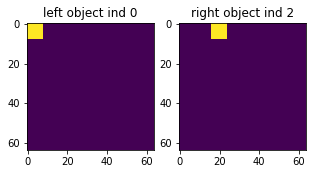

Compare objects (-1: left object win; 0: draw; 1: right object win)
1


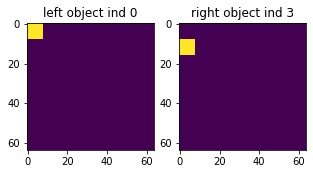

Compare objects (-1: left object win; 0: draw; 1: right object win)
1


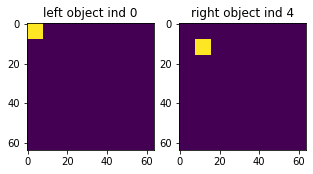

Compare objects (-1: left object win; 0: draw; 1: right object win)
0


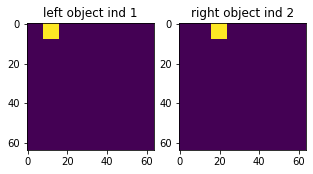

Compare objects (-1: left object win; 0: draw; 1: right object win)
0


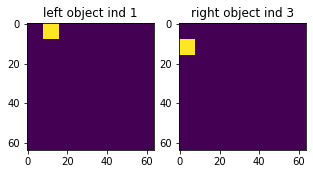

Compare objects (-1: left object win; 0: draw; 1: right object win)
-1


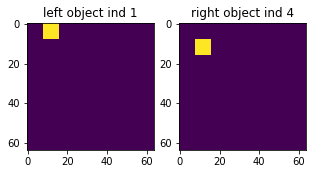

Compare objects (-1: left object win; 0: draw; 1: right object win)
-1


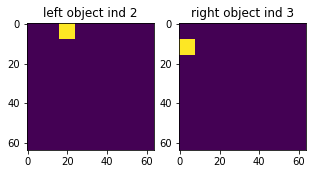

Compare objects (-1: left object win; 0: draw; 1: right object win)
1


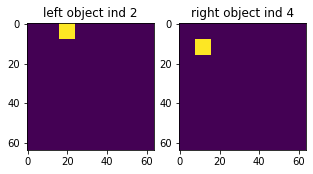

Compare objects (-1: left object win; 0: draw; 1: right object win)
1


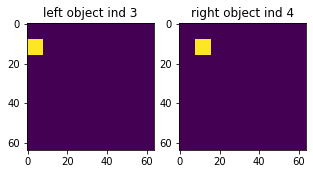

Compare objects (-1: left object win; 0: draw; 1: right object win)
0


In [9]:
a.compare_samples()

# decisions were random

let's check objects

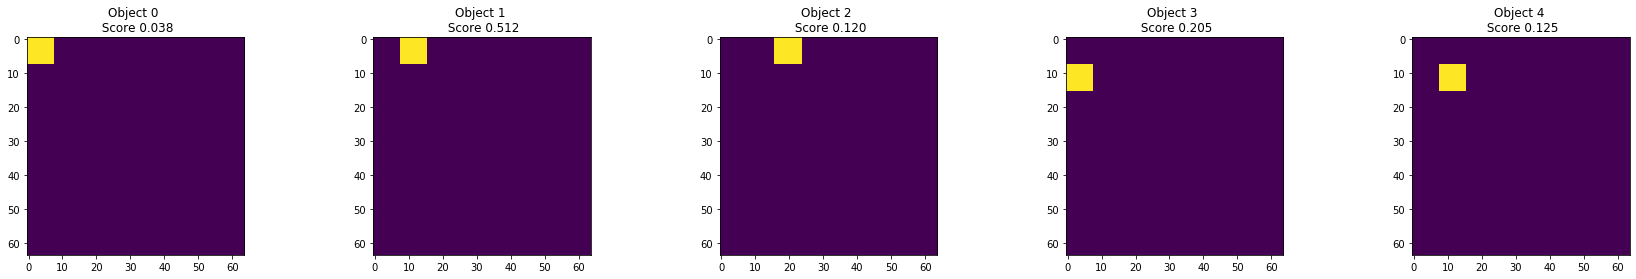

In [12]:
a.show_objects()

fit model

In [11]:
a.fit_bt()

add new object

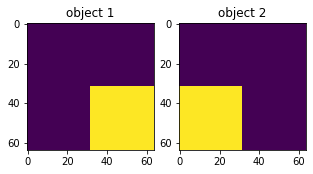

Compare objects (-1: object 1 win; 0: draw; 1: object 2 win)0


In [9]:
a.add_object(images[-1])

fit model with new object

In [10]:
a.fit_bt()

how comparison matrix now looks

In [27]:
a.comp_matrix

array([[0., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 1.],
       [1., 0., 0., 1., 0.]])

And finally how scores looks now

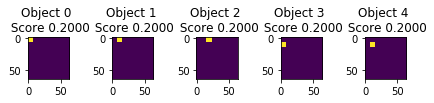

In [28]:
a.show_objects()

decisions were random

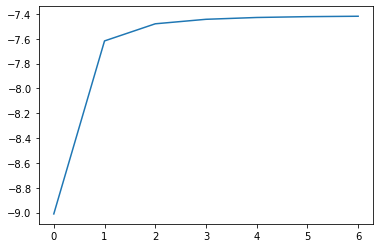

In [11]:
plt.plot(a.ll_log)